In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import QuantileTransformer, RobustScaler, KBinsDiscretizer

from time import time

In [20]:
# dataset issues:
# --------------
# - unbalance target
# - very skewed variables -> try boxcox or yeo-johnson transform
# - outliers variables -> try spatial sign

In [78]:
def plot_multi_hist(df, title=''):
    df.hist(figsize=(12, 9), rwidth=.8)
    plt.gcf().suptitle(title)

def plot_multi_kde(df, title=''):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

    for ax, col in zip(axs.flat, df.columns[:-1]):
        sns.distplot(df[col], ax=ax, rug=True, hist=False)
    fig.suptitle(title)
    #fig.tight_layout()

def my_pairplot(df, title=''):
    g = sns.pairplot(df, hue='Type', vars=df.columns[:-1])
    g.fig.suptitle(title)
    
def plot_corr(df, title=""):
    corrs = df.corr()

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(corrs, annot=True, square=True, fmt='.2f', vmin=-1., vmax=1., cmap=plt.cm.RdBu, ax=ax)
    fig.suptitle(title)
    fig.tight_layout()

In [21]:
data = pd.read_csv('data/glass.csv')

data.head()

RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

In [22]:
data['Type'] = data.Type.astype('category')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null category
dtypes: category(1), float64(9)
memory usage: 15.5 KB


In [24]:
# target distributon: highly unbalance
pd.value_counts(data['Type'])

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

In [25]:
data.nunique()

RI      178
Na      142
Mg       94
Al      118
Si      133
K        65
Ca      143
Ba       34
Fe       32
Type      6
dtype: int64

In [26]:
data.describe()

RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe  
count  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009  
std      1.423153    0.497219    0.097439  
min      5.430000    0.000000    0.000000  
25%      8.240000    0.000000    0.000000  
50%      8.600000    0.000000    0.000000  
75%      9.172500    0.000000    0.100000  
max     16.190000    3.150000    0.510000

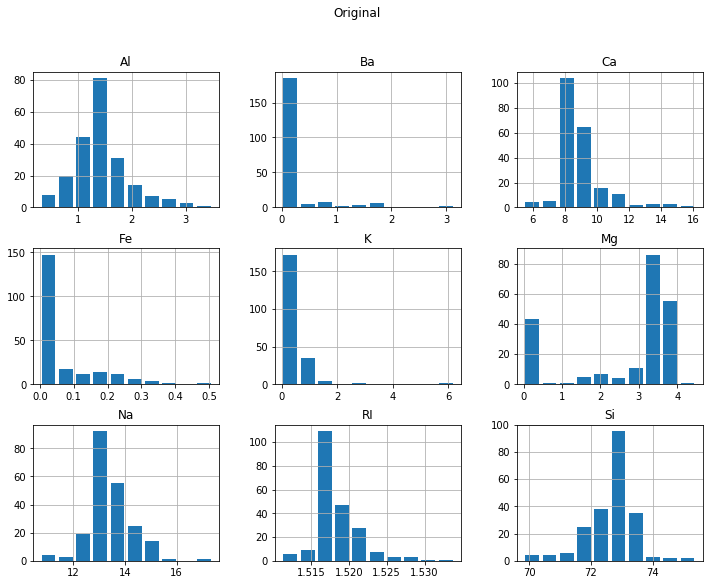

In [56]:
plot_multi_hist(data, title='Original')

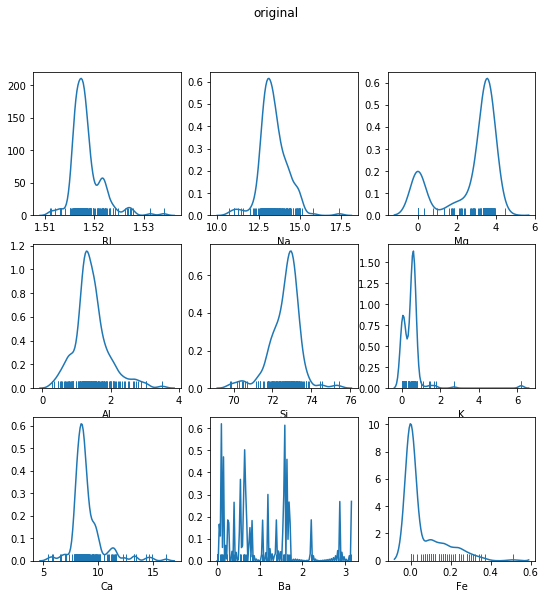

In [59]:
plot_multi_kde(data, title='original')

In [29]:
data.skew()

RI      1.625431
Na      0.454181
Mg     -1.152559
Al      0.907290
Si     -0.730447
K       6.551648
Ca      2.047054
Ba      3.416425
Fe      1.754327
Type    1.114915
dtype: float64

#### yeo-johnson transformation: dealing with skewness

In [30]:
yeojohnson_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

data_yeo = pd.DataFrame(yeojohnson_transformer.fit_transform(data.iloc[:, :-1]), 
                        columns=data.columns[:-1])
data_yeo['Type'] = data['Type'].values

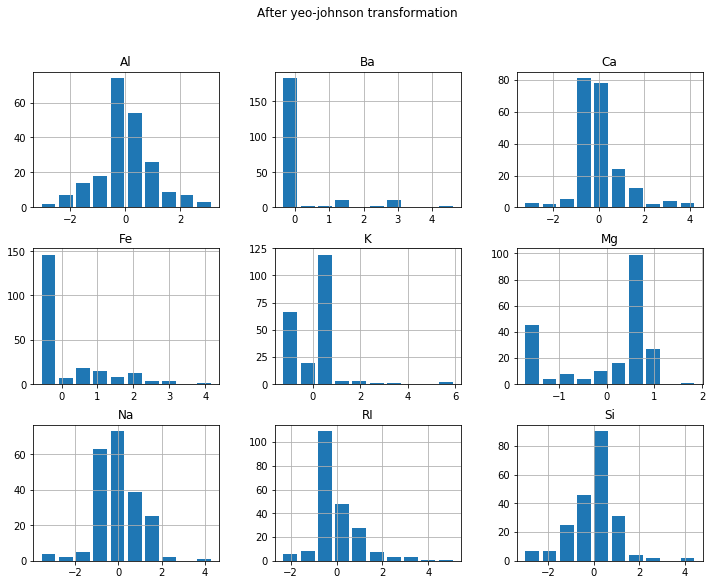

In [60]:
# histograms after yeo-johnson transformation
plot_multi_hist(data_yeo, title='After yeo-johnson transformation')

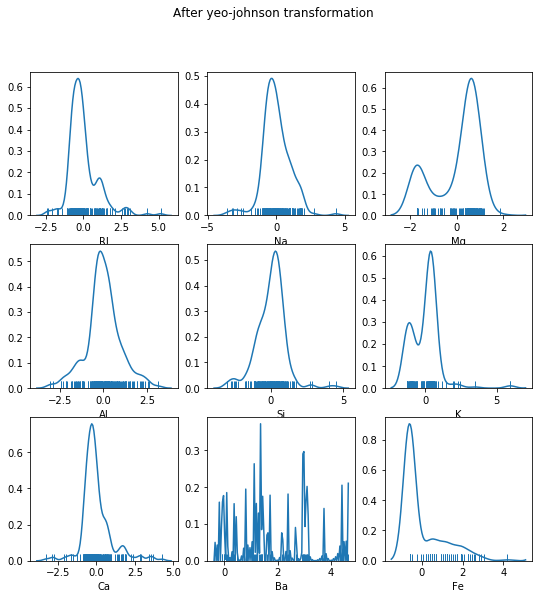

In [61]:
plot_multi_kde(data_yeo, title='After yeo-johnson transformation')

#### Spatial sign: dealing with outliers

In [40]:
spatial_sign_transform = make_pipeline(StandardScaler(), Normalizer(norm='l2'))

In [41]:
data_spatial = pd.DataFrame(spatial_sign_transform.fit_transform(data.iloc[:, :-1]), 
                            columns=data.columns[:-1])
data_spatial['Type'] = data['Type'].values

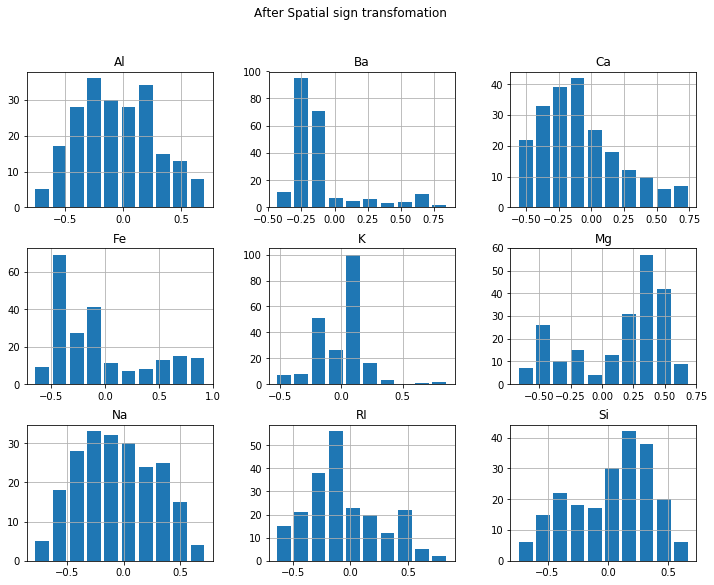

In [62]:
plot_multi_hist(data_spatial, title='After Spatial sign transfomation')

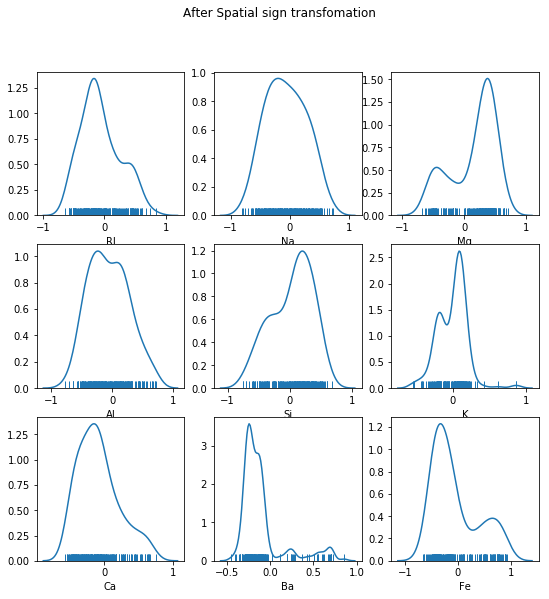

In [63]:
plot_multi_kde(data_spatial, title='After Spatial sign transfomation')

#### Plain Standardize scaling

In [44]:
sc = StandardScaler()

data_std = pd.DataFrame(sc.fit_transform(data.iloc[:, :-1]), columns=data.columns[:-1])
data_std['Type'] = data['Type'].values

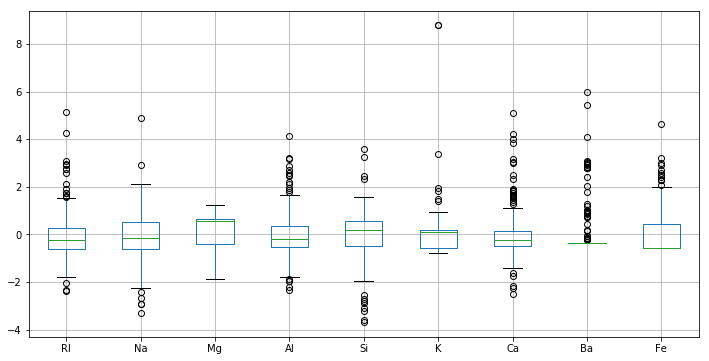

In [45]:
data_std.drop('Type', axis=1).boxplot(figsize=(12, 6))

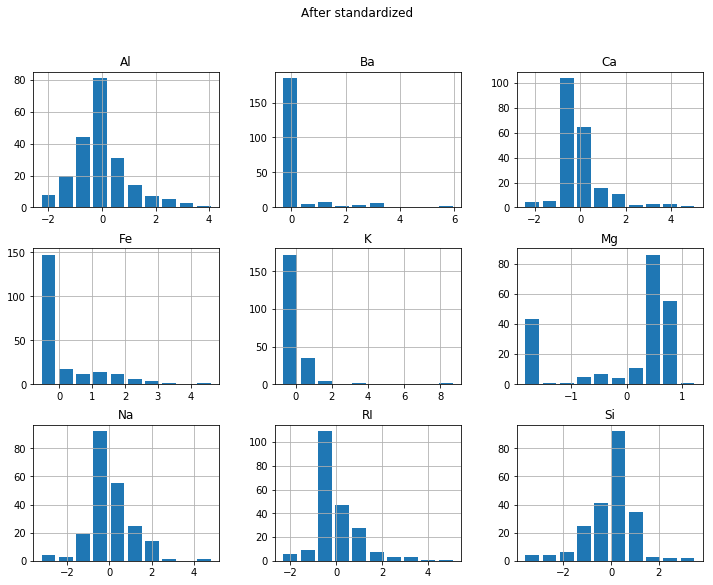

In [64]:
plot_multi_hist(data_std, title='After standardized')

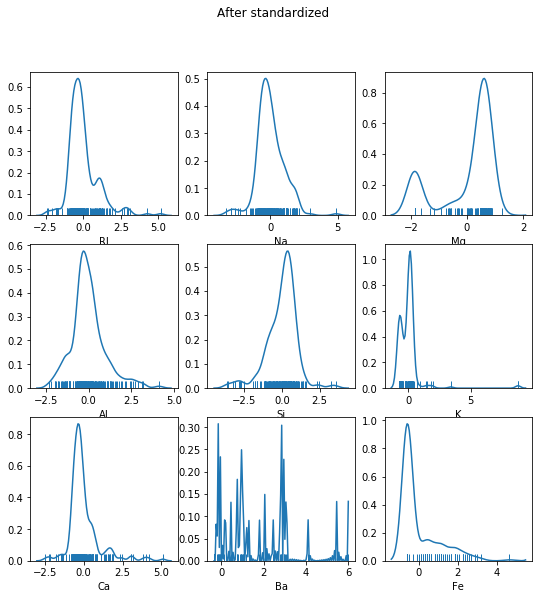

In [65]:
plot_multi_kde(data_std, title='After standardized')

In [148]:
# robust scaler, quantile transformer, kbinsdiscretizer
robust = RobustScaler()
robust.fit(data.iloc[:, :-1])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [149]:
data_robust = pd.DataFrame(robust.transform(data.iloc[:, :-1]), columns=data.columns[:-1])

In [150]:
data_robust['Type'] = data['Type'].values

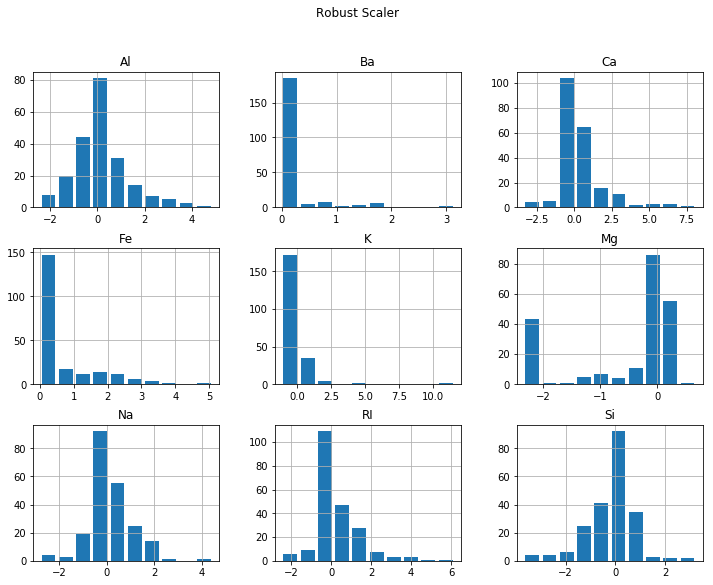

In [151]:
plot_multi_hist(data_robust, title='Robust Scaler')

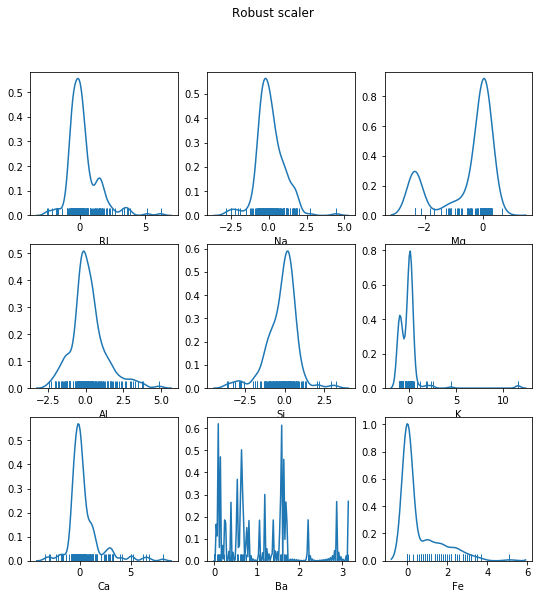

In [152]:
plot_multi_kde(data_robust, title='Robust scaler')

In [158]:
qt_uni = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
qt_normal = QuantileTransformer(n_quantiles=100, output_distribution='normal')

In [159]:
data_qt_uni = pd.DataFrame(qt_uni.fit_transform(data.iloc[:, :-1]), 
                           columns=data.columns[:-1])
data_qt_normal = pd.DataFrame(qt_normal.fit_transform(data.iloc[:, :-1]),
                              columns=data.columns[:-1])

data_qt_uni['Type'] = data['Type'].values
data_qt_normal['Type'] = data['Type'].values

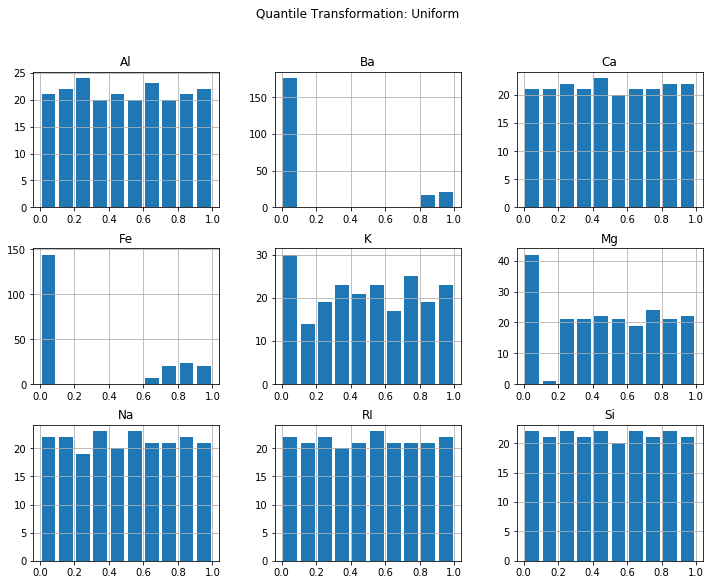

In [160]:
plot_multi_hist(data_qt_uni, title='Quantile Transformation: Uniform')

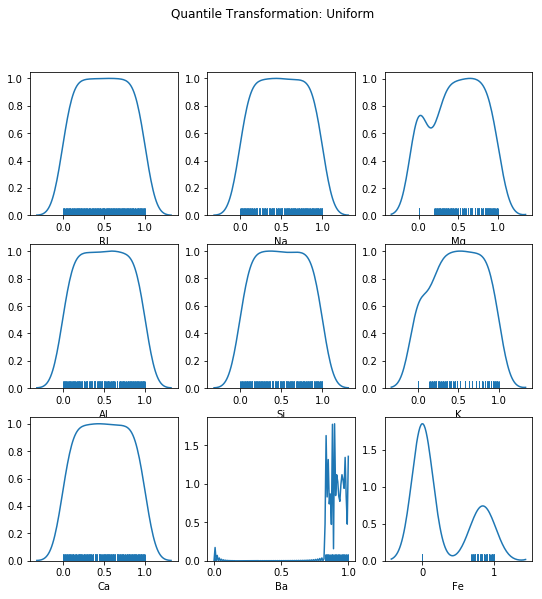

In [161]:
plot_multi_kde(data_qt_uni, title='Quantile Transformation: Uniform')

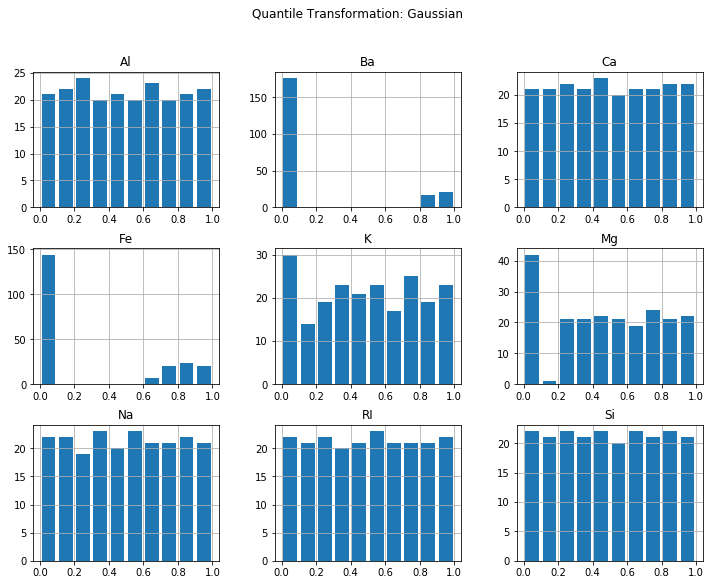

In [162]:
plot_multi_hist(data_qt_uni, title='Quantile Transformation: Gaussian')

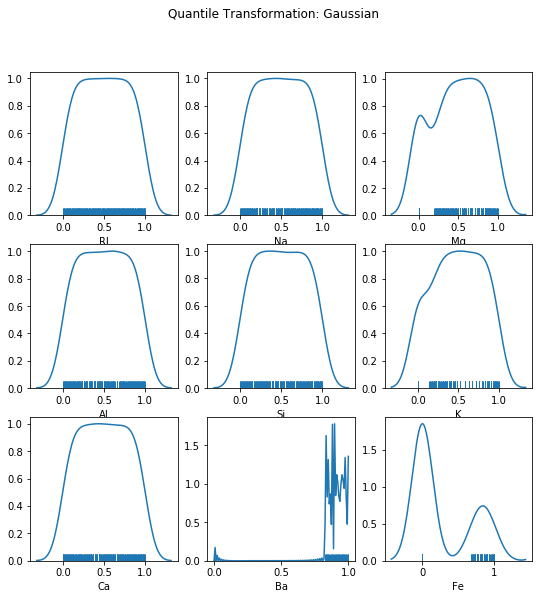

In [163]:
plot_multi_kde(data_qt_uni, title='Quantile Transformation: Gaussian')

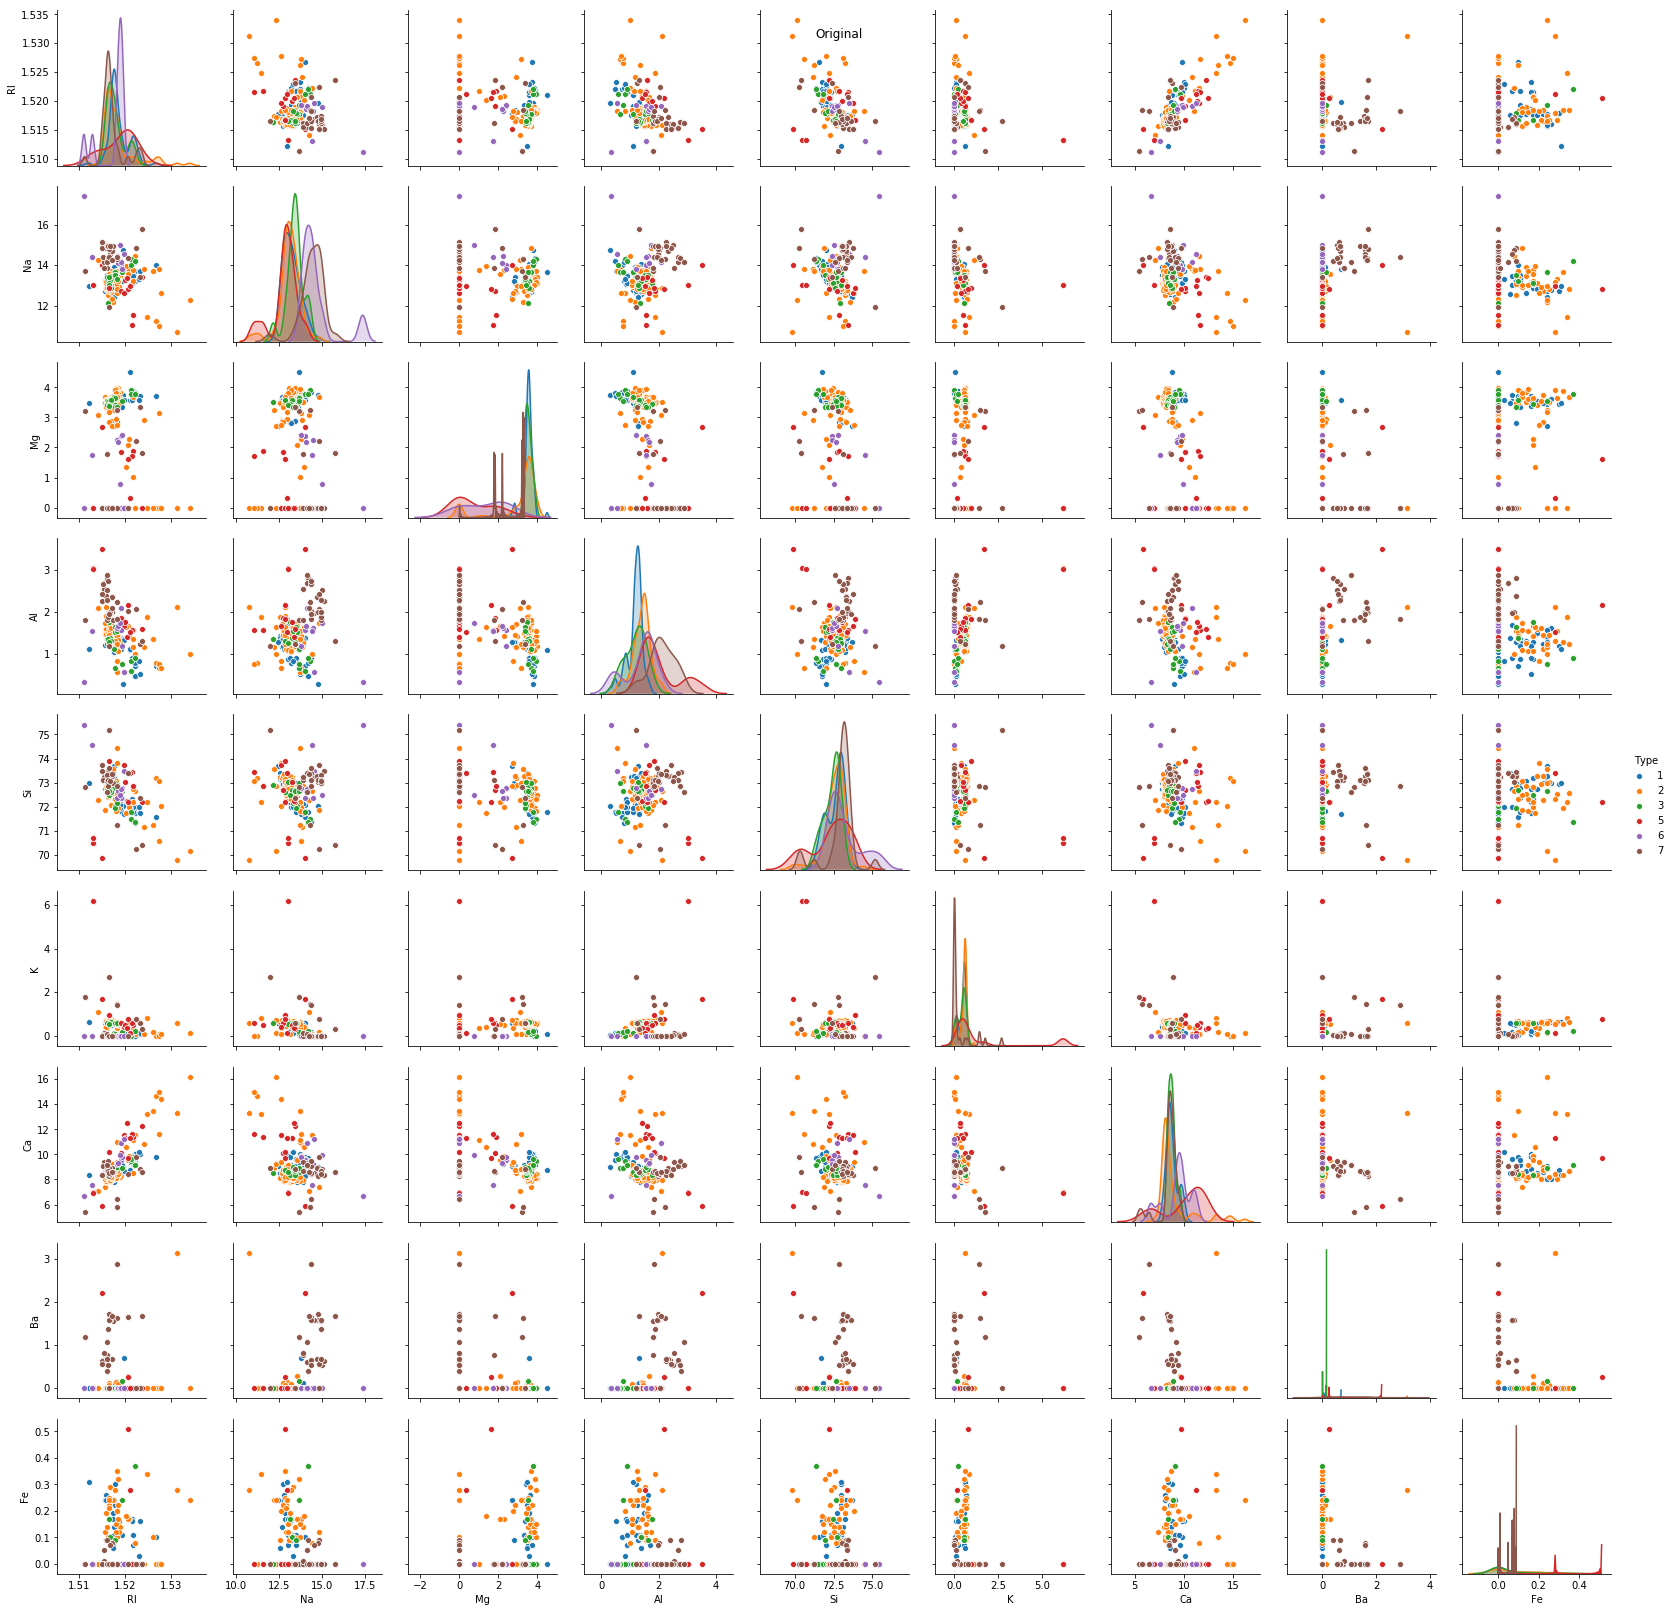

In [66]:
my_pairplot(data, title='Original')

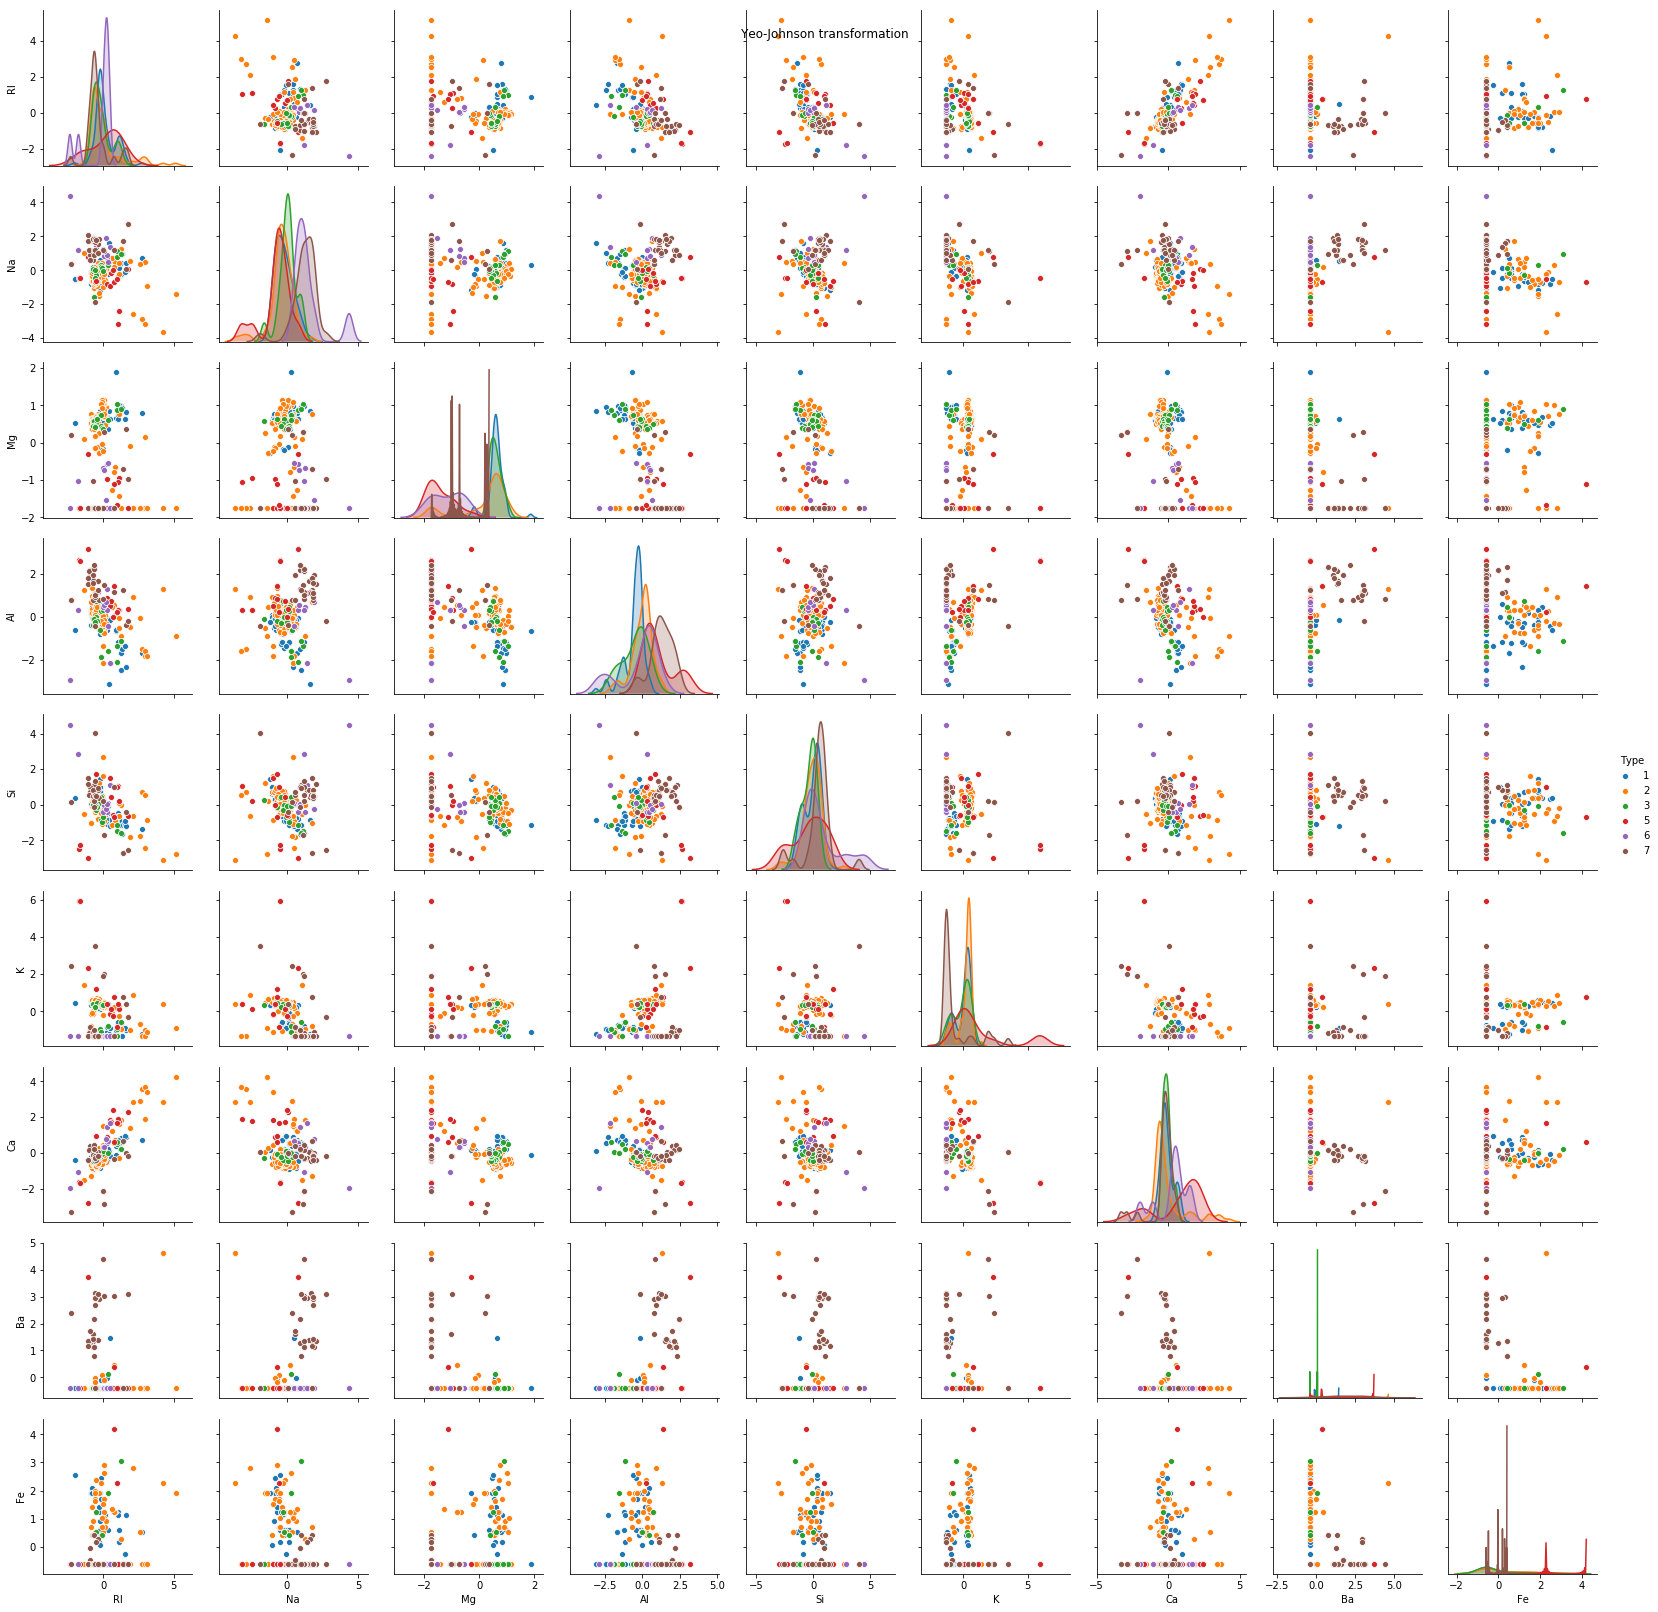

In [67]:
my_pairplot(data_yeo, title='Yeo-Johnson transformation')

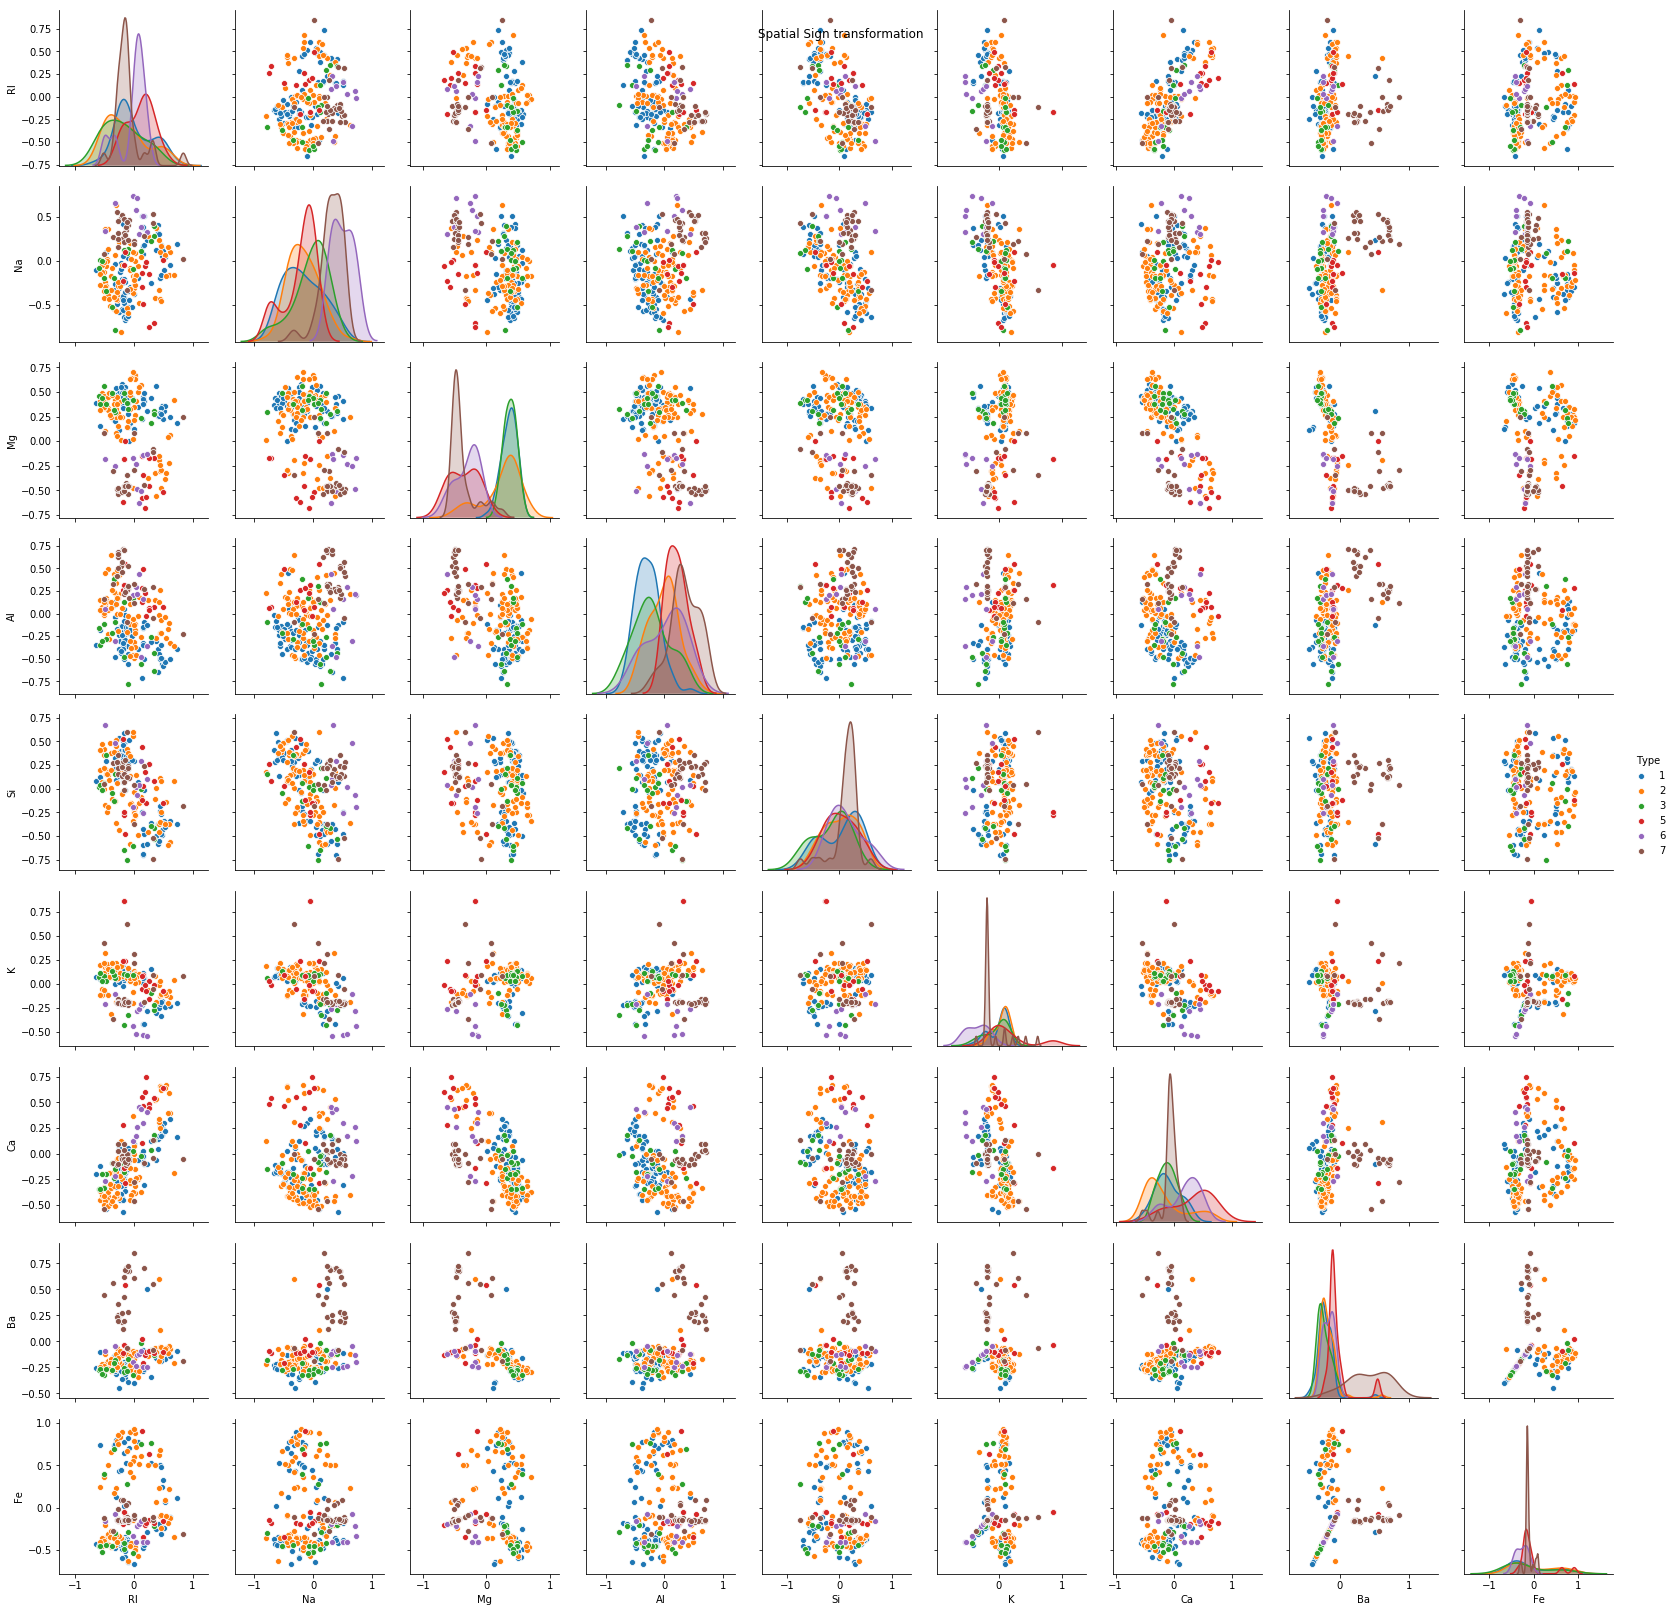

In [68]:
my_pairplot(data_spatial, title='Spatial Sign transformation')

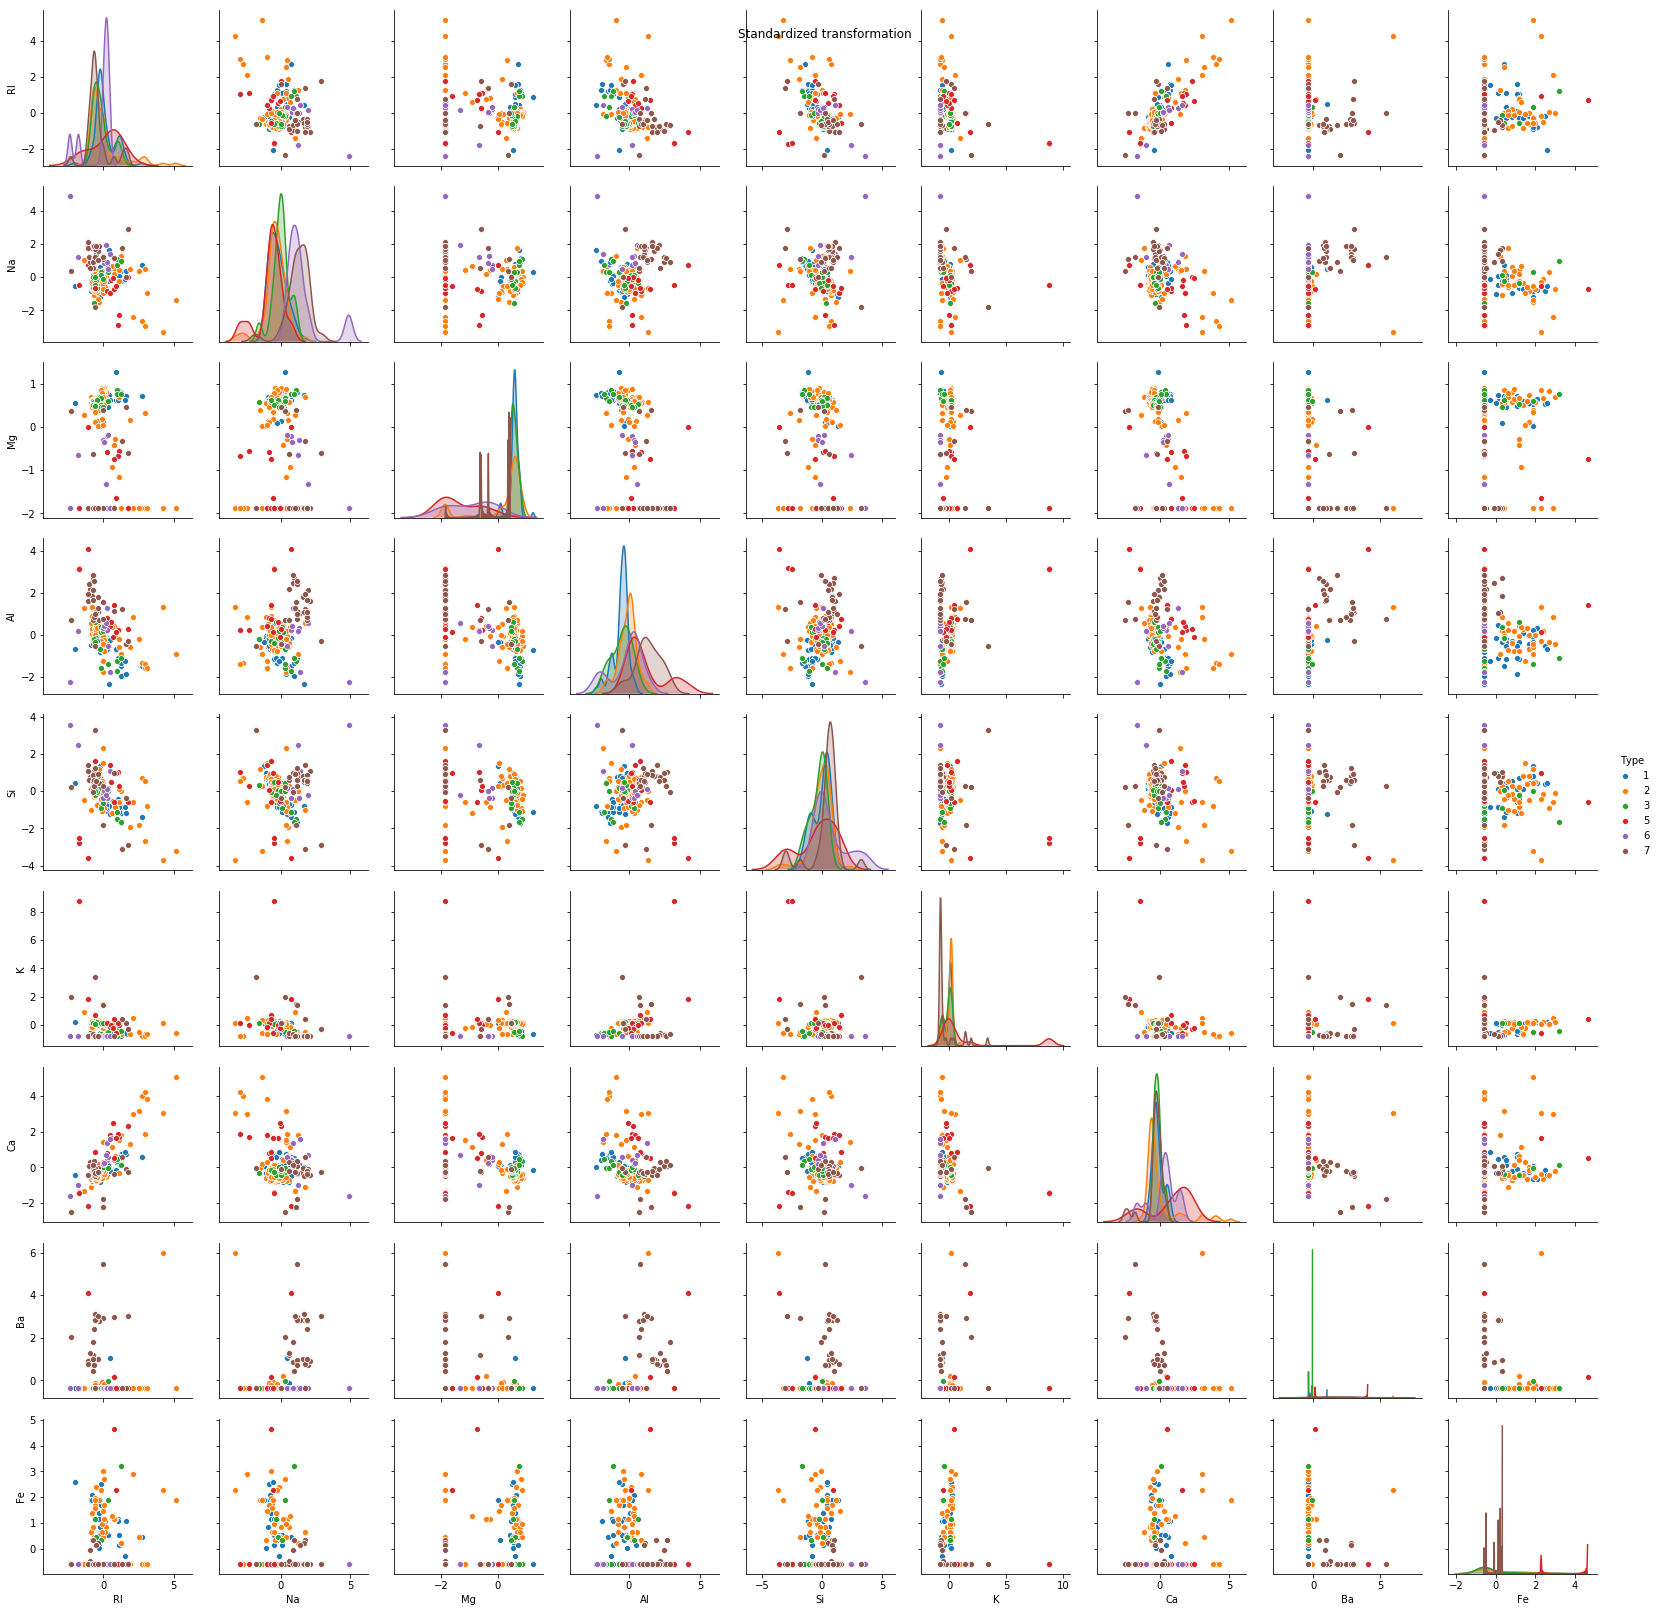

In [69]:
my_pairplot(data_std, title='Standardized transformation')

#### Correlations

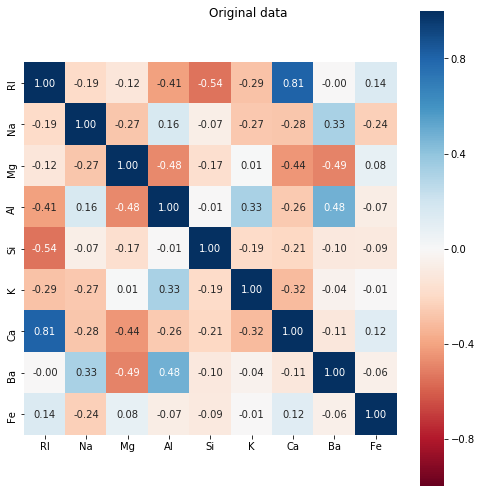

In [79]:
plot_corr(data, 'Original data')

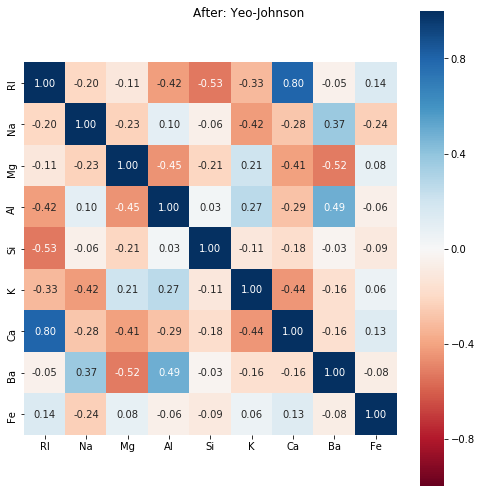

In [81]:
plot_corr(data_yeo, 'After: Yeo-Johnson')

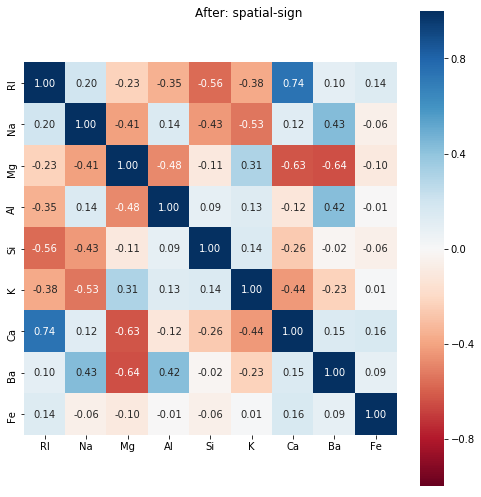

In [82]:
plot_corr(data_spatial, title='After: spatial-sign')

In [84]:
data['K'][:5]

0    0.06
1    0.48
2    0.39
3    0.57
4    0.55
Name: K, dtype: float64

In [91]:
def is_outlier(x):
    q1, q3 = np.quantile(x, q=[.25, .75])
    IQR = q3 - q1
    return np.where(np.logical_or(x < q1 - 1.5*IQR, x > q3+1.5*IQR), True, False)

def make_outlier_by_cols(df):
    cols = df.columns
    results = []
    for col in cols:
        results.append(is_outlier(df[col]))
    return pd.DataFrame(results, index=cols).T

In [93]:
outliers_df = make_outlier_by_cols(data.iloc[:, :-1])

In [96]:
outliers_df['total_outlier'] = outliers_df.sum(axis=1).values

In [98]:
outliers_df['Type'] = data['Type'].values

In [108]:
outliers_df.query('total_outlier > 2') 

RI     Na     Mg     Al     Si      K     Ca     Ba     Fe  \
103   True  False  False  False   True  False   True  False  False   
105   True   True  False  False  False  False   True  False   True   
106   True   True  False  False   True  False   True   True   True   
107   True  False  False  False   True  False   True  False  False   
110   True   True  False  False  False  False   True  False  False   
111   True   True  False  False  False  False   True  False  False   
163  False  False  False   True   True   True   True   True  False   
171  False  False  False   True   True   True  False  False  False   
172  False  False  False   True   True   True  False  False  False   
184   True   True  False   True   True  False   True  False  False   
185   True  False  False  False  False   True   True   True  False   
186  False  False  False  False  False   True   True   True  False   
189   True   True  False  False   True  False  False   True  False   
207  False  False  False  False  False   True   True   True  False   

     total_outlier Type  
103              3    2  
105              4    2  
106              6    2  
107              3    2  
110              3    2  
111              3    2  
163              5    5  
171              3    5  
172              3    5  
184              5    6  
185              4    7  
186              3    7  
189              4    7  
207              3    7

In [110]:
std_pca = make_pipeline(StandardScaler(), PCA(n_components=.95))
spatial_pca = make_pipeline(StandardScaler(), Normalizer(), PCA(n_components=.95))

In [111]:
data_pca = pd.DataFrame(std_pca.fit_transform(data.iloc[:, :-1]))
data_spatial_pca = pd.DataFrame(spatial_pca.fit_transform(data.iloc[:, :-1]))

In [112]:
data_pca.columns = ['PC{}'.format(i) for i in range(1, data_pca.shape[1]+1)]
data_spatial_pca.columns = ['PC{}'.format(i) for i in range(1, data_spatial_pca.shape[1]+1)]

data_pca['Type'] = data['Type'].values
data_spatial_pca['Type'] = data['Type'].values

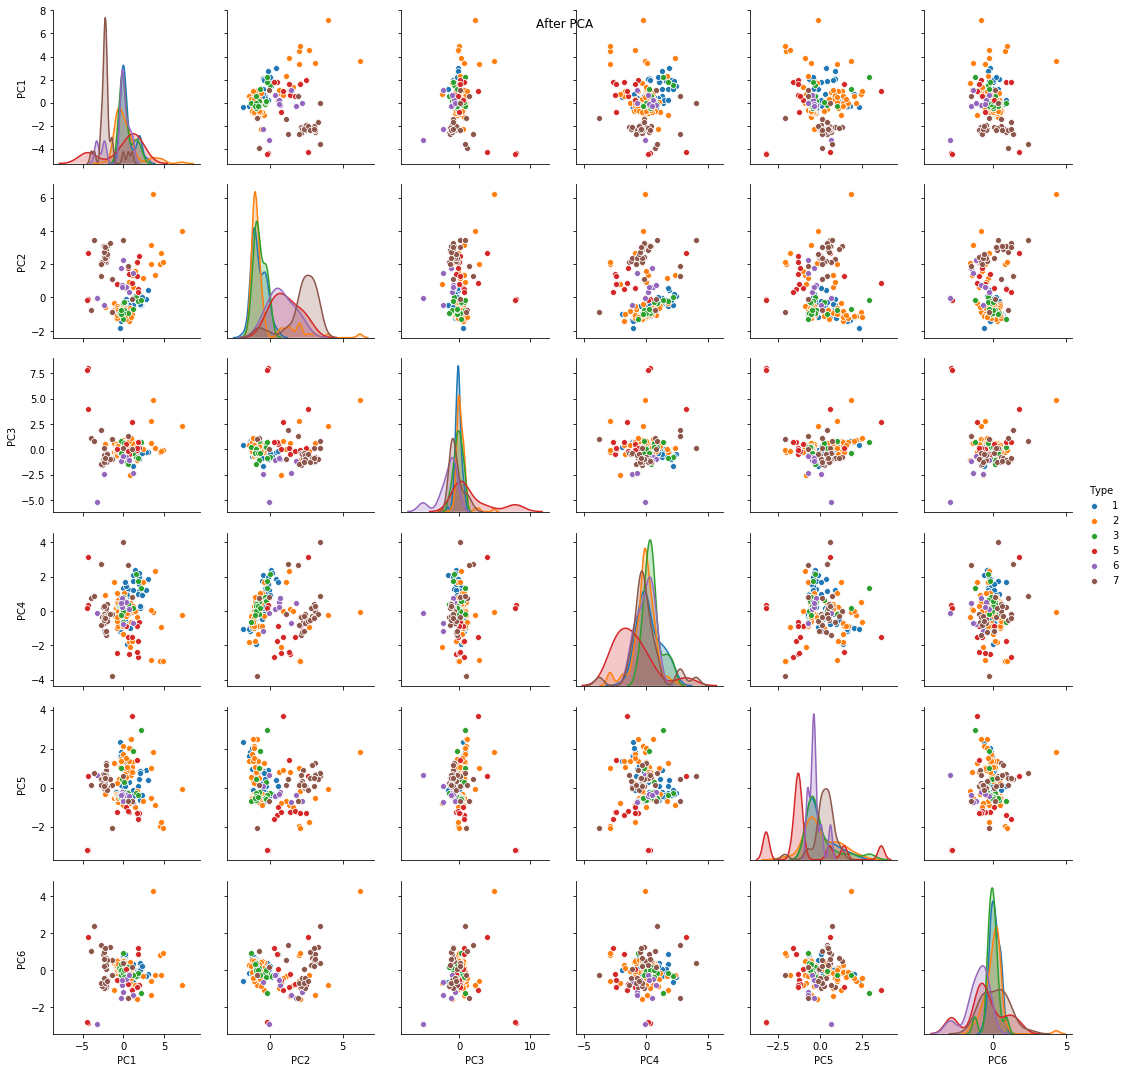

In [115]:
my_pairplot(data_pca, title='After PCA')

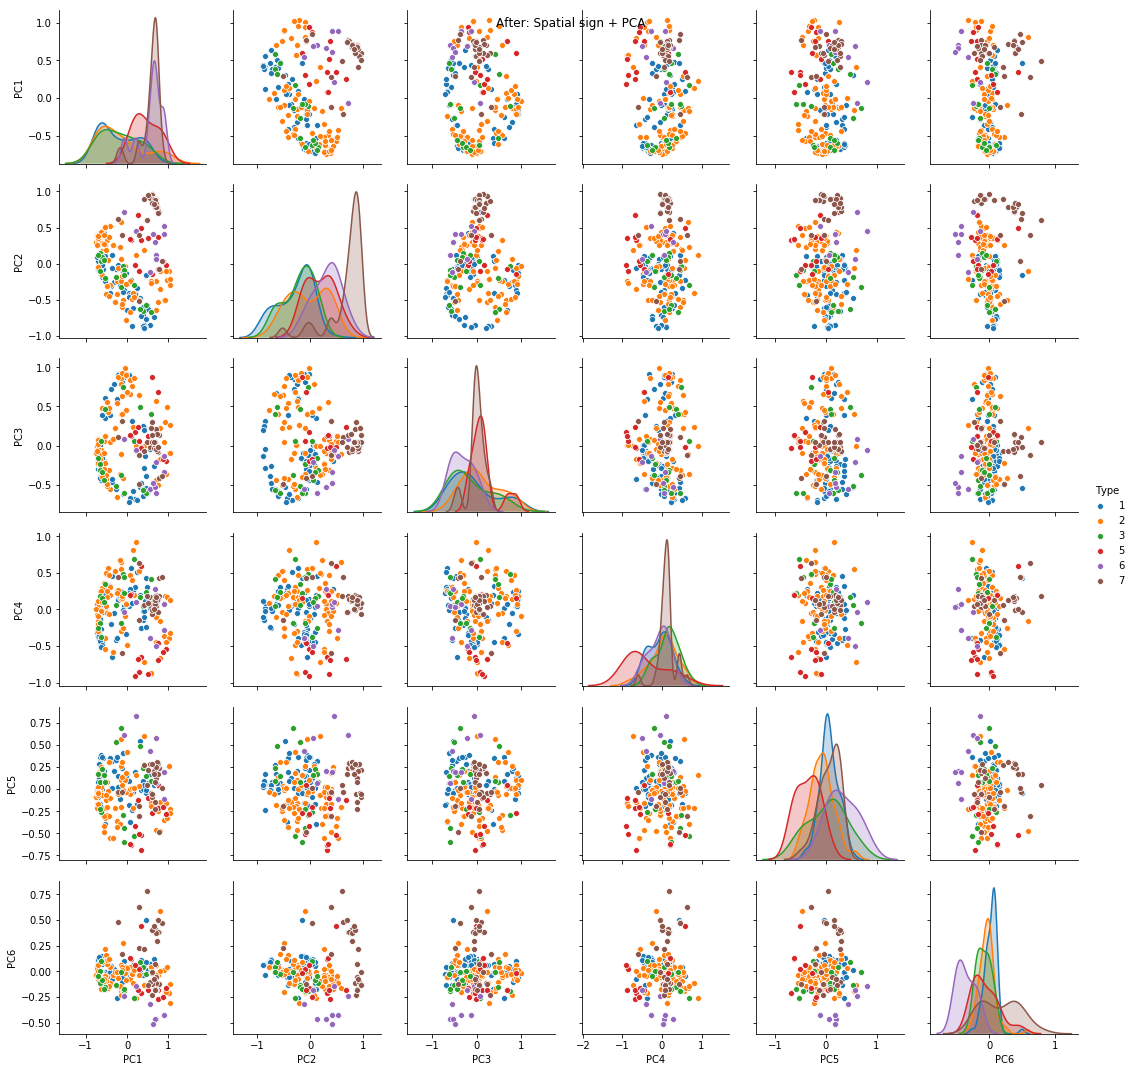

In [116]:
my_pairplot(data_spatial_pca, title='After: Spatial sign + PCA')

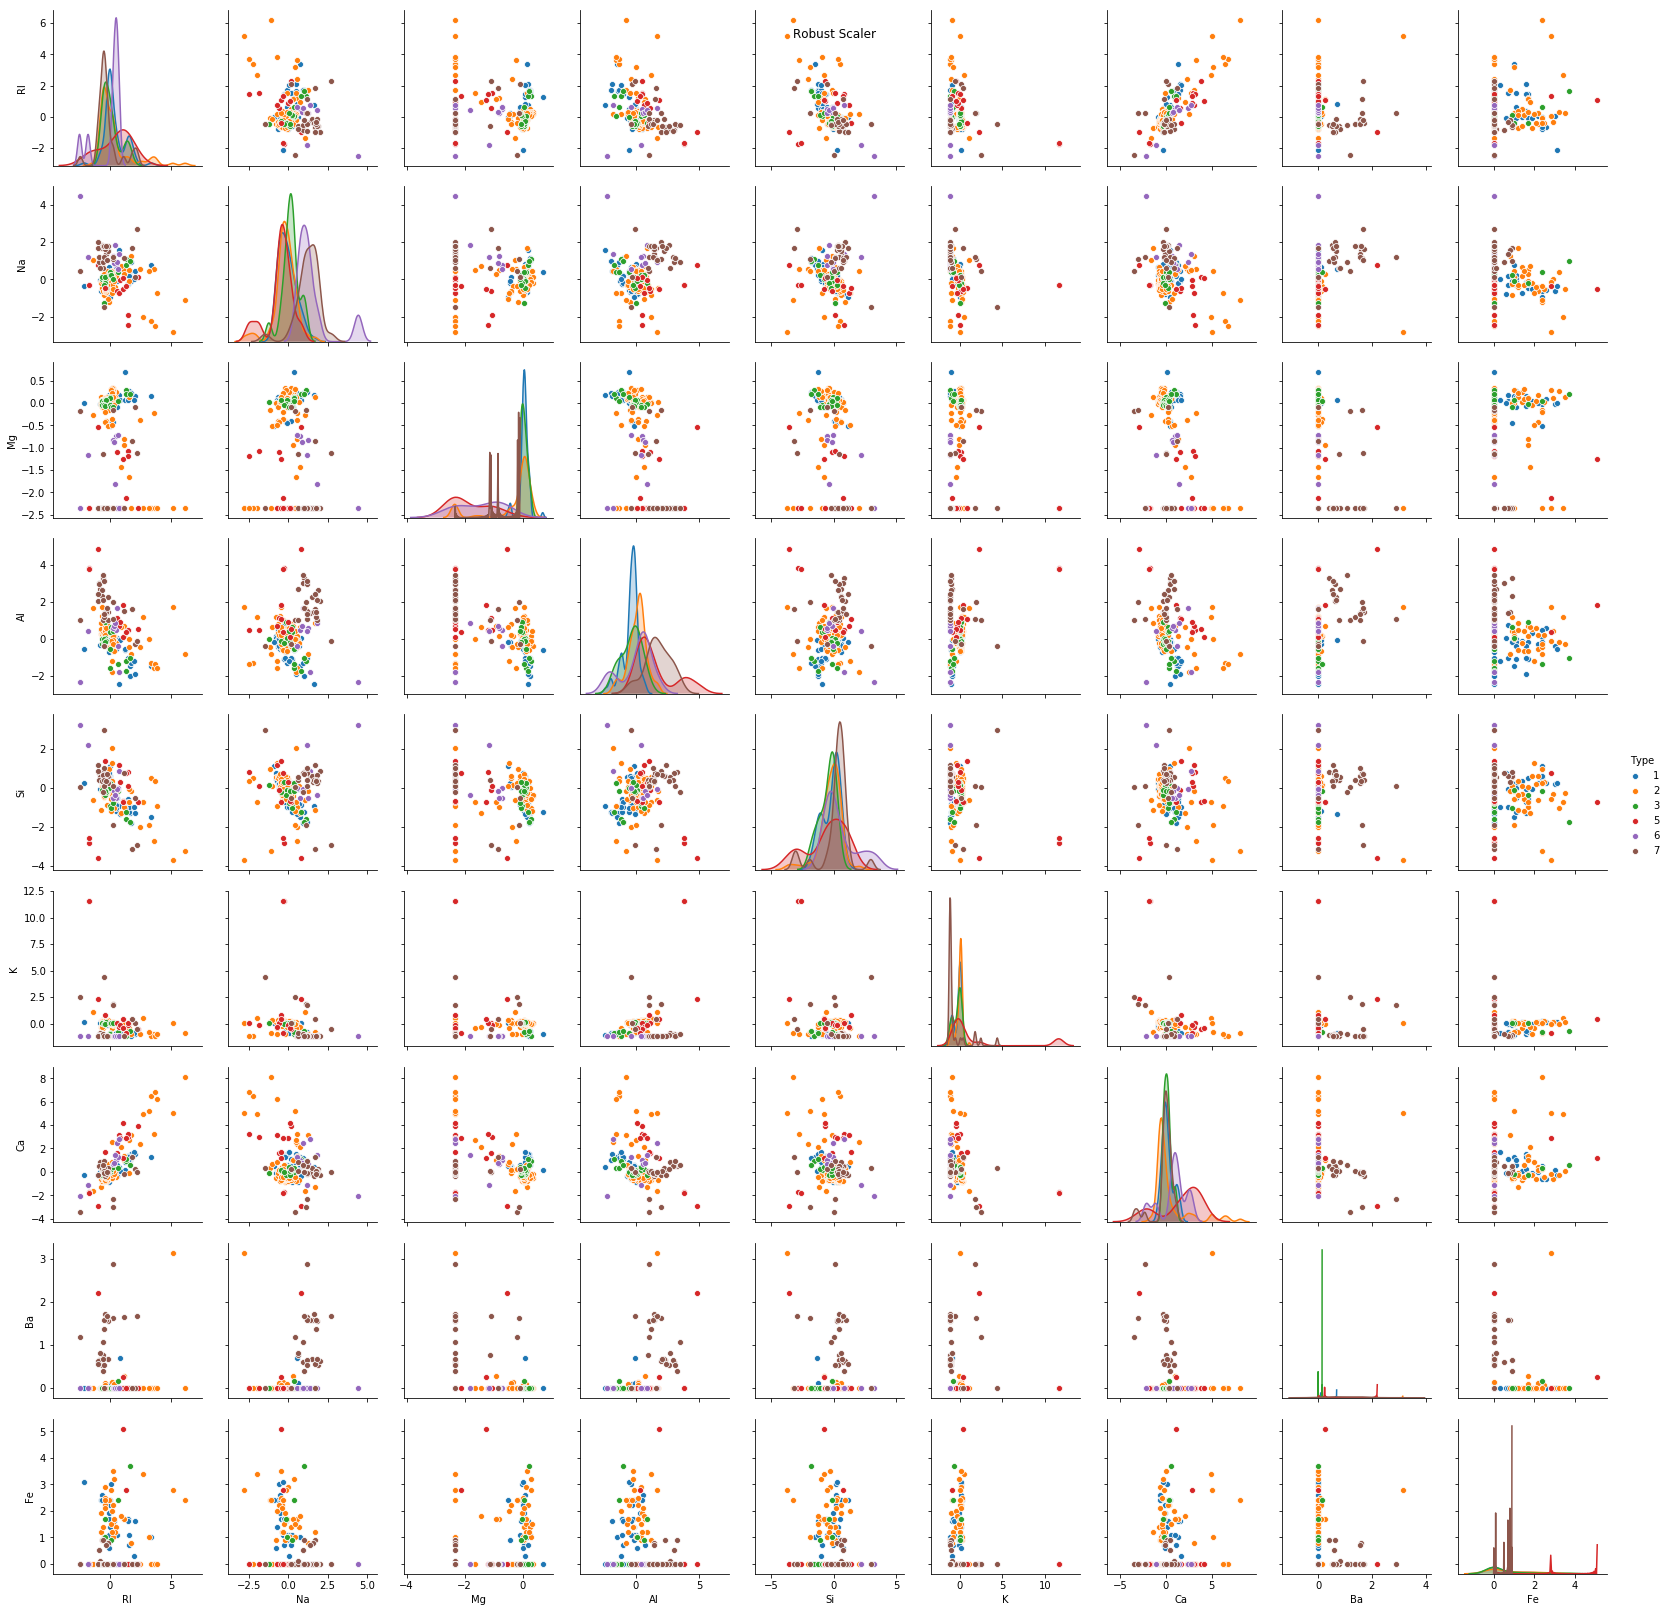

In [164]:
my_pairplot(data_robust, title='Robust Scaler')

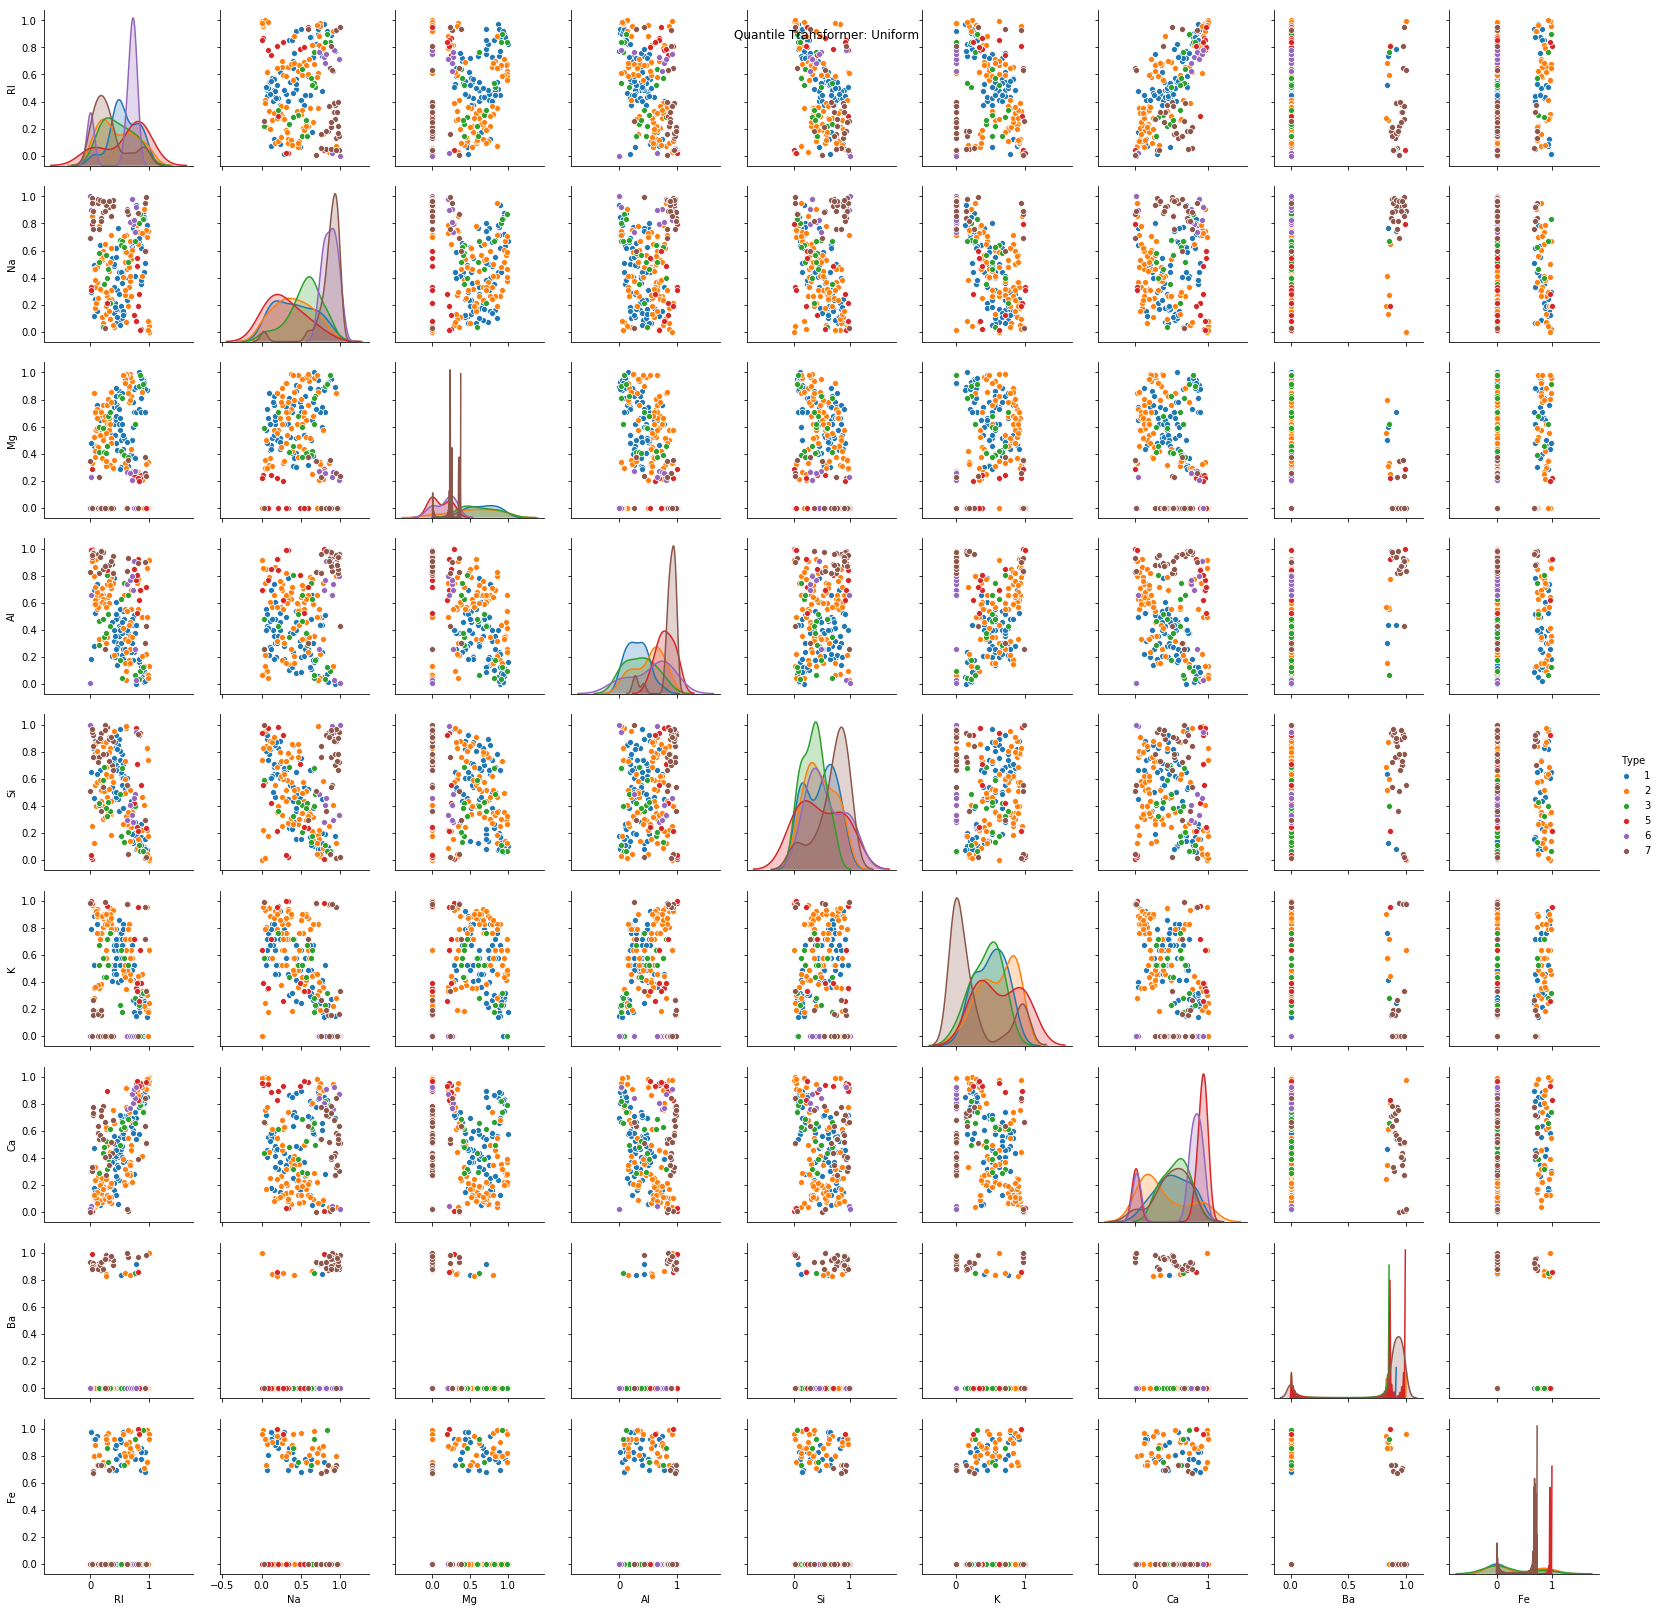

In [165]:
my_pairplot(data_qt_uni, title='Quantile Transformer: Uniform')

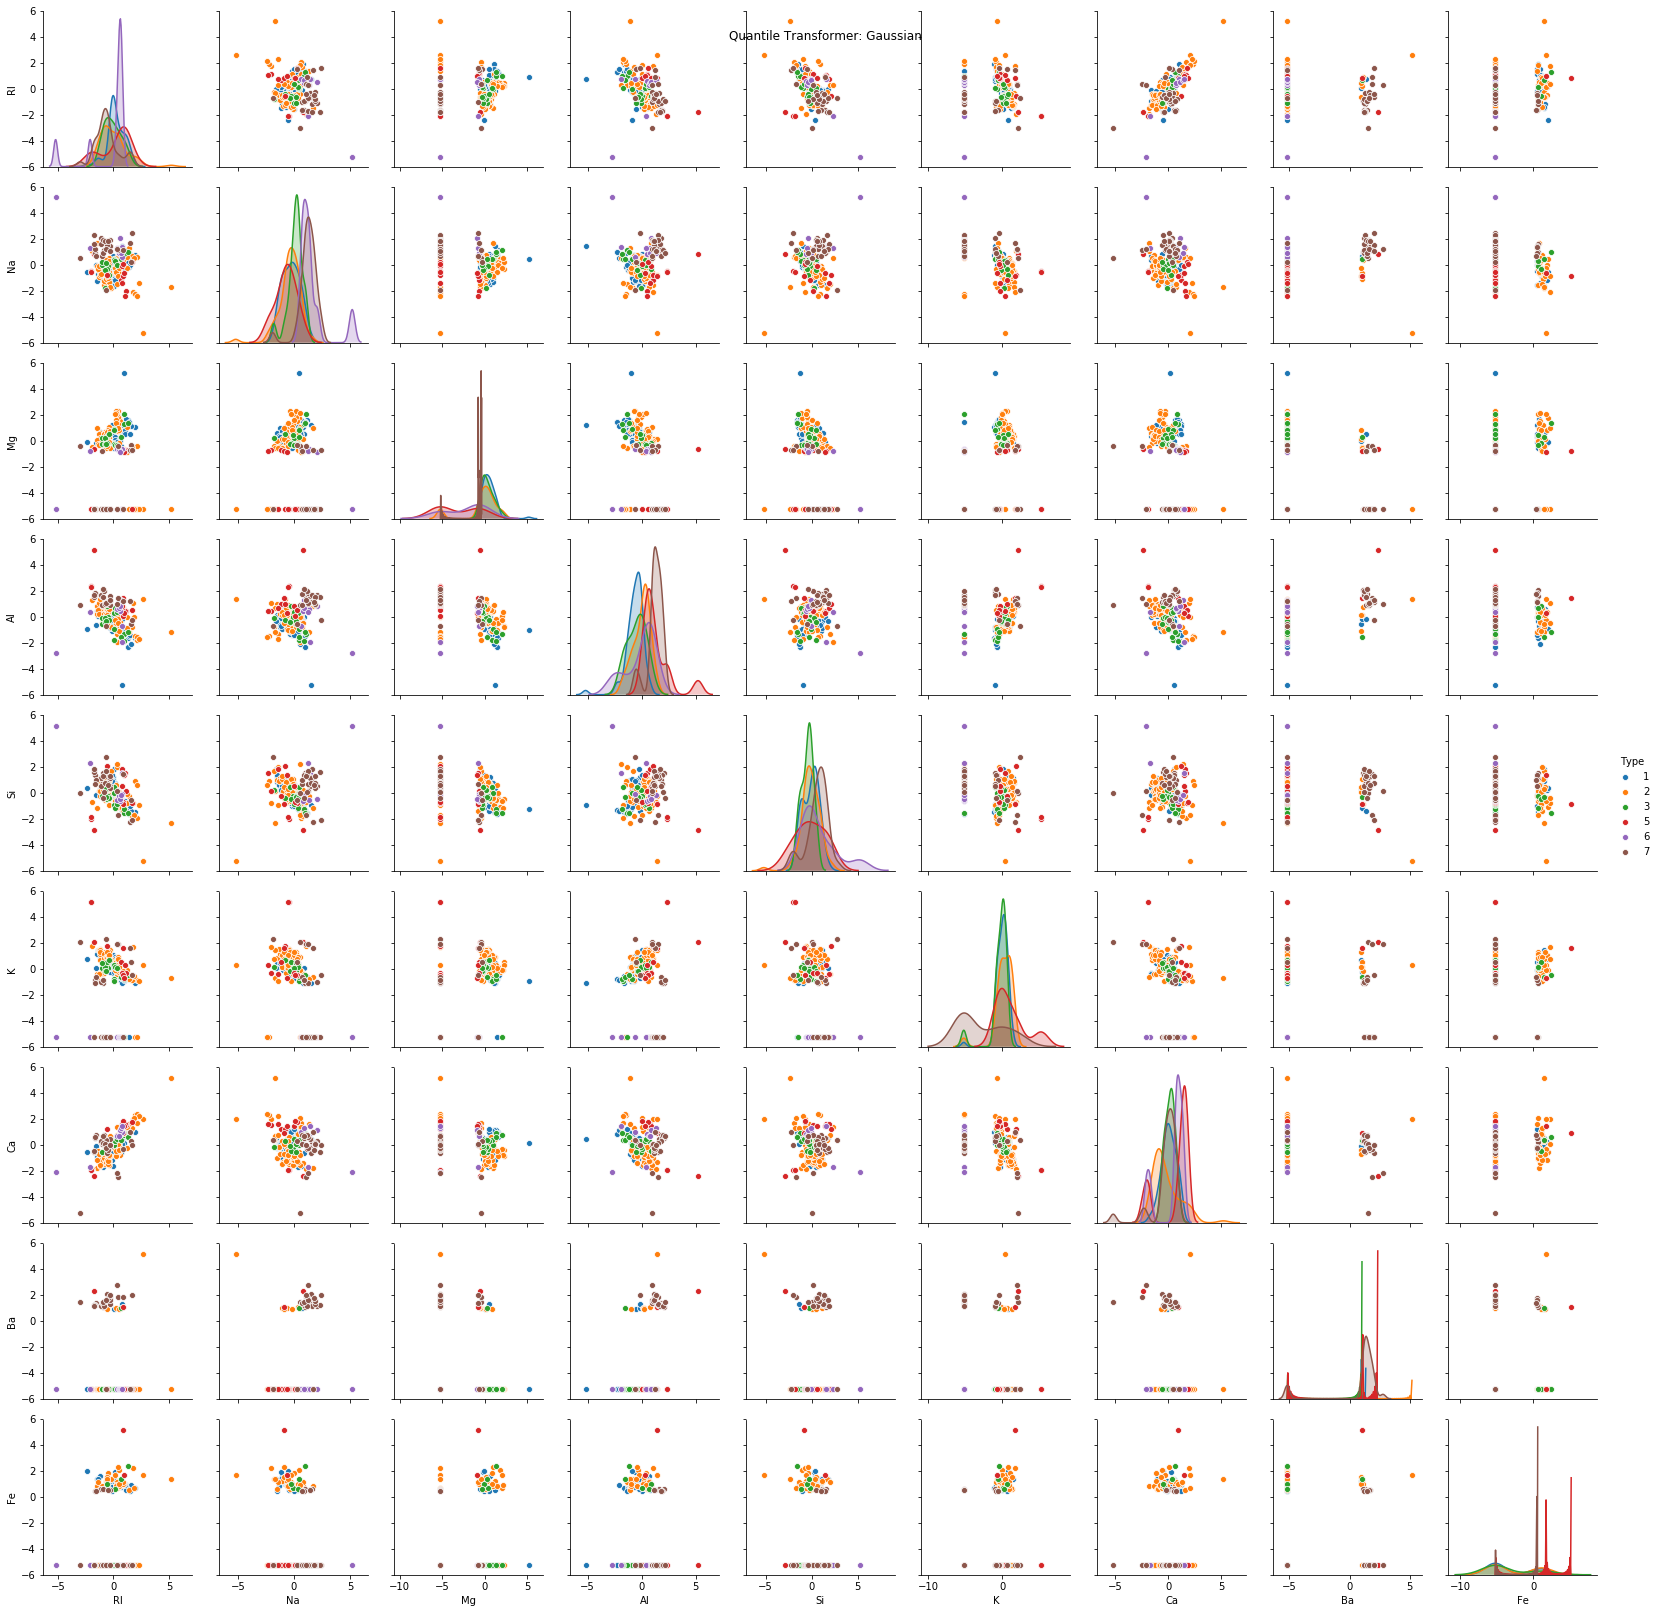

In [166]:
my_pairplot(data_qt_normal, title='Quantile Transformer: Gaussian')

#### 2d scatter plots using PCA

In [185]:
# use data after yeo-johnson transformation
pca = PCA(n_components=2)
X_2d = pca.fit_transform(data_yeo.iloc[:, :-1])

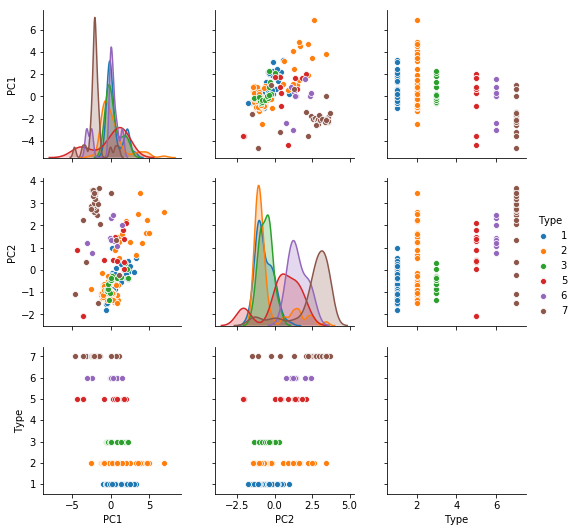

In [196]:
sns.pairplot(hue='Type', 
                data=(pd.DataFrame(X_2d, columns=['PC1','PC2'])
                         .assign(Type=data['Type'].values)))

#### Modeling

In [172]:
X = data.drop('Type', axis=1)
y = data['Type']

X.shape, y.shape

((214, 9), (214,))

In [171]:
k10 = StratifiedKFold(n_splits=10)

In [168]:
preprocess_choices = {
    'scaler': StandardScaler(),
    'robust': RobustScaler(),
    'yeo_johnson': PowerTransformer(),
    'quantile_uniform': QuantileTransformer(n_quantiles=100, 
                                            output_distribution='uniform'),
    'quantile_gauss': QuantileTransformer(n_quantiles=100, 
                                          output_distribution='normal'),
    'kbin': KBinsDiscretizer(n_bins=3, encode='onehot')
}

model_choices = {
    'svc': SVC(),
    'logreg': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier()
}

In [170]:
all_pipes = {}
for pre in preprocess_choices:
    for model in model_choices:
        pipe_name = "{}_{}".format(pre, model)
        pipe = Pipeline([
            (pre, preprocess_choices[pre]),
            (model, model_choices[model])
        ])
        all_pipes[pipe_name] = pipe

In [179]:
result_dict = {}

for name, pipe in all_pipes.items():
    t0 = time()
    cv_result = cross_val_score(pipe, X, y, scoring='accuracy', 
                                cv=k10, n_jobs=2)
    t = time() - t0
    print("{:30}: mean accuracy {:.3f} +/- {:.3f}, running time: {:.3f} s".format(name, cv_result.mean(), 
                                                                            cv_result.std(), t))
    result_dict[name] = cv_result

kbin_rfc                                : mean accuracy 0.643 +/- 0.142, running time: 0.964 s
kbin_svc                                : mean accuracy 0.605 +/- 0.090, running time: 0.269 s
scaler_rfc                              : mean accuracy 0.660 +/- 0.156, running time: 0.865 s
yeo_johnson_knn                         : mean accuracy 0.686 +/- 0.081, running time: 0.576 s
kbin_knn                                : mean accuracy 0.637 +/- 0.098, running time: 0.187 s
quantile_gauss_logreg                   : mean accuracy 0.544 +/- 0.109, running time: 0.395 s
quantile_uniform_gbc                    : mean accuracy 0.713 +/- 0.107, running time: 4.496 s
yeo_johnson_svc                         : mean accuracy 0.675 +/- 0.109, running time: 0.494 s
kbin_gbc                                : mean accuracy 0.651 +/- 0.119, running time: 5.111 s
quantile_uniform_rfc                    : mean accuracy 0.692 +/- 0.157, running time: 1.124 s
quantile_gauss_knn                      : mean acc

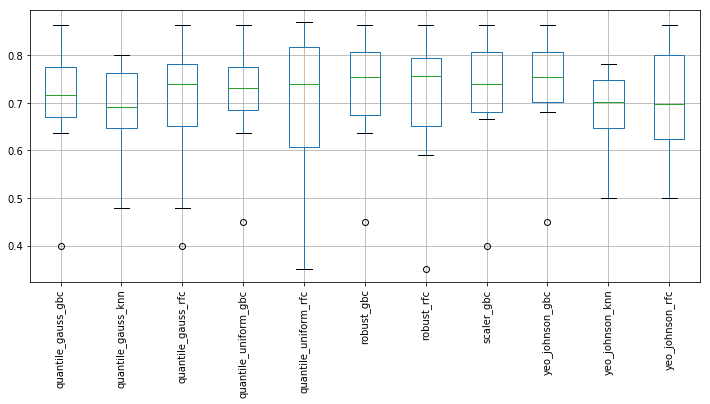

In [183]:
(pd.DataFrame({k:v for k, v in result_dict.items() if v.mean() > .68})
     .boxplot(figsize=(12, 5), rot=90)
)

In [199]:
all_pipes['yeo_johnson_gbc']

Pipeline(memory=None,
     steps=[('yeo_johnson', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [214]:
param_grid = {
    'gbc__n_estimators': [100, 200],
    'gbc__learning_rate':np.logspace(-3, -1, 6),
    'gbc__max_leaf_nodes': np.arange(2, 16, 3),
    'gbc__max_depth': [None],
    'gbc__min_samples_leaf': [5, 10, 15, 20],
    'gbc__max_features': [None, 'log2', 'sqrt']
}

In [227]:
gbc_grid = GridSearchCV(all_pipes['yeo_johnson_gbc'], param_grid=param_grid, cv=k10,
                        scoring='accuracy', verbose=2)

In [228]:
gbc_grid.fit(X, y)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nod

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=10, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=10, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10, total=   0.4s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_le

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.4s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.4s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.4s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=2, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_le

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nod

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=10, total=   0.2s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10, total=   0.5s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10, total=   0.5s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_le

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.5s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.5s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.5s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=5, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_le

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.3s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.3s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5, total=   0.3s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=5 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nod

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10, total=   0.7s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10, total=   0.7s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10, total=   0.7s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=10 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_le

[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.6s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.7s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=200, gbc__min_samples_leaf=15, total=   0.7s
[CV] gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_leaf_nodes=8, gbc__max_depth=None, gbc__n_estimators=100, gbc__min_samples_leaf=20 
[CV]  gbc__max_features=None, gbc__learning_rate=0.001, gbc__max_le

KeyboardInterrupt: 

In [217]:
gbc_grid.best_score_, gbc_grid.best_params_

(0.7570093457943925,
 {'gbc__learning_rate': 0.1,
  'gbc__max_depth': None,
  'gbc__max_features': 'sqrt',
  'gbc__max_leaf_nodes': 5,
  'gbc__min_samples_leaf': 15,
  'gbc__n_estimators': 100})

In [218]:
{'gbc__learning_rate': 0.1,
  'gbc__max_depth': None,
  'gbc__max_features': 'sqrt',
  'gbc__max_leaf_nodes': 5,
  'gbc__min_samples_leaf': 15,
  'gbc__n_estimators': 100}

{'gbc__learning_rate': 0.1,
 'gbc__max_depth': None,
 'gbc__max_features': 'sqrt',
 'gbc__max_leaf_nodes': 5,
 'gbc__min_samples_leaf': 15,
 'gbc__n_estimators': 100}

In [232]:
best_gbc = gbc_grid.estimator.set_params(**{'gbc__learning_rate': 0.1,
                                              'gbc__max_depth': None,
                                              'gbc__max_features': 'sqrt',
                                              'gbc__max_leaf_nodes': 5,
                                              'gbc__min_samples_leaf': 15,
                                              'gbc__n_estimators': 100})

In [243]:
cv_result = cross_val_score(best_gbc, X, y, cv=k10, scoring='accuracy')

In [244]:
print("{:.3f} +/- {:.3f}".format(cv_result.mean(), cv_result.std()))

0.732 +/- 0.128


In [246]:
cv_result

array([0.69565217, 0.82608696, 0.69565217, 0.59090909, 0.77272727,
       0.86363636, 0.9047619 , 0.45      , 0.8       , 0.72222222])